# [Baseball Databank](http://www.seanlahman.com/baseball-archive/statistics/)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
from typing import Tuple, Callable

In [4]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [5]:
# show matplotlib plots in notebook
%matplotlib inline

In [6]:
# set matplotlib style/theme
plt.style.use("fivethirtyeight")

In [7]:
# plotly defaults
pio.renderers.default = "notebook"
pio.templates.default = "seaborn"

In [8]:
from tabulate import tabulate
from IPython.core.display import display, Markdown, HTML

def markdown(s: str):
    display(Markdown(s))
    
def html(s: str):
    display(HTML(s))

In [9]:
# path to data files
datapath = Path("../baseballdatabank/core")

___________________
### Batting info

In [10]:
batting_all = pd.read_csv(datapath/"batting.csv")

### People info

In [13]:
people = pd.read_csv(datapath/"people.csv")
for col in "debut", "finalGame":
    people[col] = pd.to_datetime(people[col])

In [14]:
# slimmed people dataframe with player ID, full name, first and final games as datetimes
people_slim = pd.concat([people["playerID"], 
                         people[["nameFirst", "nameLast"]].fillna("").agg(" ".join, axis=1).rename("fullName"), 
                         people["debut"].apply(lambda dt: dt.year).fillna(0).astype(np.int), 
                         people["finalGame"].apply(lambda dt: dt.year).fillna(0).astype(np.int)], 
                        axis=1)

In [15]:
people_slim.head(2)

,playerID,fullName,debut,finalGame
0,aardsda01,David Aardsma,2004,2015
1,aaronha01,Hank Aaron,1954,1976


_____________________________________________

# Team stats

In [17]:
teams = pd.read_csv(datapath/"teams.csv")

In [20]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   yearID          2955 non-null   int64  
 1   lgID            2905 non-null   object 
 2   teamID          2955 non-null   object 
 3   franchID        2955 non-null   object 
 4   divID           1438 non-null   object 
 5   Rank            2955 non-null   int64  
 6   G               2955 non-null   int64  
 7   Ghome           2556 non-null   float64
 8   W               2955 non-null   int64  
 9   L               2955 non-null   int64  
 10  DivWin          1410 non-null   object 
 11  WCWin           774 non-null    object 
 12  LgWin           2927 non-null   object 
 13  WSWin           2598 non-null   object 
 14  R               2955 non-null   int64  
 15  AB              2955 non-null   int64  
 16  H               2955 non-null   int64  
 17  2B              2955 non-null   i

-----------------------------
##### Look at how/if certain stats have changed over time.
scaling per-game seems reasonable since the number of games per season 
- increased significantly between the 1871 and 1905
- increased slightly around 1960
- has infrequent but significant changes (e.g. 2020)

i.e. ....

[Text(0.5, 1.0, 'Games per season'), Text(0.5, 0, ''), Text(0, 0.5, '')]

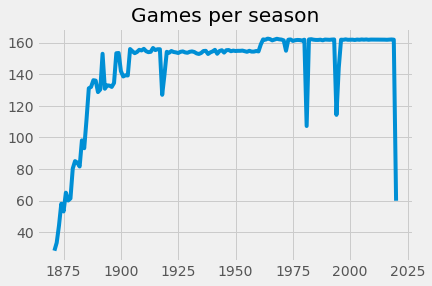

In [795]:
sns_lp = sns.lineplot(data=teams.pivot_table(index="yearID", values="G"), x="yearID", y="G")
sns_lp.set(title="Games per season", xlabel=None, ylabel=None)

--------------------------

In [705]:
from itertools import chain

In [707]:
def stat_per_game(stats):
    df = teams.pivot_table(index="yearID", 
                           values=chain(stats, ["G"]), 
                           aggfunc=np.sum)
    return df.divide(df["G"], axis="index") \
             .drop("G", axis=1) \
             .reset_index()

_____________________________
## Offense over time

In [736]:
off_stats = ["H", "R", "HR", "BB"]
off_per_game = stat_per_game(off_stats)
off_per_game.head(2)

,yearID,BB,H,HR,R
0,1871,1.547244,12.208661,0.185039,10.468504
1,1872,0.718579,12.204918,0.101093,9.262295


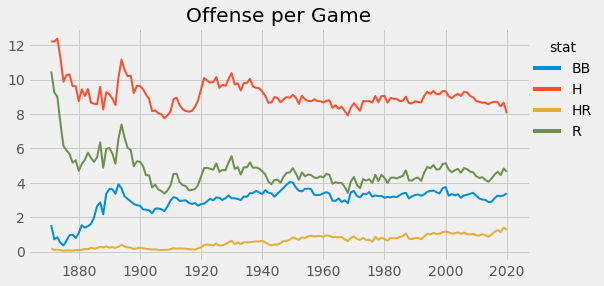

In [761]:
plt.figure(figsize=(8,4))
sns_lp = sns.lineplot(x='yearID', 
             y='value', 
             hue='variable', 
             data=pd.melt(off_per_game, ['yearID']), 
             linewidth=2)
sns_lp.set(xlabel=None, ylabel=None, title="Offense per Game")
plt.legend(title="stat", bbox_to_anchor=(1.15, 1), loc='upper right', frameon=False)

In [722]:
bp = px.line(off_per_game, 
            x="yearID",
            y=["HR", "H", "R", "BB"],
            title="Offense per Game")
bp.update_traces(hovertemplate="<b>%{x}</b><br>%{y:.3f}", line=dict(width=3))
bp.update_layout(legend=dict(title="stat"))
bp.update_xaxes(title=None)
bp.update_yaxes(title=None)
bp.show()

It seems like these offensive stats really haven't changed all that much since about 1920 (though some have *slightly* increased).

## Defense over time

In [796]:
# Pitching/fielding-focused, since several stats (HRA, RA, HRA, etc) are just the inverse of above
def_stats = ["SOA", "E", "DP"]
def_per_game = stat_per_game(def_stats)

# handle ERA separately since it's already an average and scaling per-game presents a somewhat confusing value
df = teams.pivot_table(index="yearID", 
                       values="ERA", 
                       aggfunc=np.mean)

def_per_game = pd.merge(def_per_game, df, on="yearID")
def_per_game.tail(2)

,yearID,DP,E,SOA,ERA
148,2019,0.825237,0.596542,8.814944,4.497000
149,2020,0.797327,0.577394,8.678174,4.447667


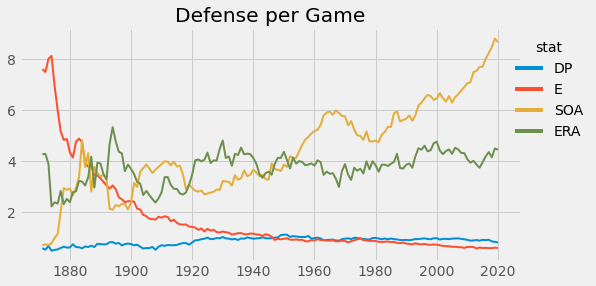

In [785]:
plt.figure(figsize=(8,4))
sns_lp = sns.lineplot(x='yearID', 
             y='value', 
             hue='variable', 
             data=pd.melt(def_per_game, ['yearID']), 
             linewidth=2)
sns_lp.set(xlabel=None, ylabel=None, title="Defense per Game")
plt.legend(title="stat", bbox_to_anchor=(1.15, 1), loc='upper right', frameon=False)

In [788]:
bp = px.line(def_per_game, 
            x="yearID",
            y=def_stats + ["ERA"],
            title="Defense per Game")
bp.update_traces(hovertemplate="<b>%{x}</b><br>%{y:.3f}", line=dict(width=3))
bp.update_layout(legend=dict(title="stat"))
bp.update_xaxes(title=None)
bp.update_yaxes(title=None)
bp.show()

Defensive stats have varied a bit more than offensive, but still within a relatively limited range. Strikeouts (```SOA```) have notably increased, while double-plays (```DP```) and errors (```E```) have slightly decreased over the past few decades. ERA has been steady, albeit with some small variance.

______________________________________________